# German Podcast Transcript Analysis

This notebook analyzes transcripts from the top German podcasts to extract insights about content, themes, and language patterns.

In [29]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("📊 Libraries loaded successfully!")

📊 Libraries loaded successfully!


In [30]:
# Download German stopwords if not already available
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    german_stopwords = set(stopwords.words('german'))
    print("✅ German stopwords loaded")
except:
    # Fallback German stopwords if NLTK fails
    german_stopwords = {
        'der', 'die', 'und', 'in', 'den', 'von', 'zu', 'das', 'mit', 'sich', 
        'des', 'auf', 'für', 'ist', 'im', 'dem', 'nicht', 'ein', 'eine', 'als', 
        'auch', 'es', 'an', 'werden', 'aus', 'er', 'hat', 'dass', 'sie', 'nach', 
        'wird', 'bei', 'einer', 'um', 'am', 'sind', 'noch', 'wie', 'einem', 'über', 
        'einen', 'so', 'zum', 'war', 'haben', 'nur', 'oder', 'aber', 'vor', 'zur', 
        'bis', 'mehr', 'durch', 'man', 'sein', 'wurde', 'sei', 'in', 'ja', 'nein', 
        'ich', 'du', 'wir', 'ihr', 'mich', 'mir', 'uns', 'euch', 'ihm', 'ihr'
    }
    print("⚠️ Using fallback German stopwords")

# Add custom stopwords for podcast transcripts
custom_stopwords = {
    'ja', 'nein', 'okay', 'ok', 'äh', 'ähm', 'also', 'genau', 'halt', 'eben',
    'mal', 'dann', 'jetzt', 'hier', 'da', 'schon', 'noch', 'wirklich', 'eigentlich',
    'vielleicht', 'können', 'sagen', 'gehen', 'kommen', 'machen', 'müssen', 'wollen'
}

all_stopwords = german_stopwords.union(custom_stopwords)
print(f"📚 Total stopwords: {len(all_stopwords)}")

✅ German stopwords loaded
📚 Total stopwords: 250


In [31]:
def load_transcripts():
    """Load all available transcripts from the data directory"""
    data_dir = Path("data")
    transcripts = []
    
    if not data_dir.exists():
        print(f"❌ Data directory {data_dir} not found!")
        return pd.DataFrame()
    
    print(f"🔍 Scanning for transcripts in {data_dir}...")
    
    total_txt_files = 0
    total_json_files = 0
    
    for podcast_dir in data_dir.iterdir():
        if podcast_dir.is_dir():
            podcast_name = podcast_dir.name
            
            for file_path in podcast_dir.iterdir():
                if file_path.suffix == '.txt':
                    total_txt_files += 1
                    try:
                        # Read transcript text
                        with open(file_path, 'r', encoding='utf-8') as f:
                            transcript_text = f.read().strip()
                        
                        if not transcript_text:
                            continue
                        
                        # Try to load corresponding JSON metadata
                        json_path = file_path.with_suffix('.json')
                        metadata = {}
                        
                        if json_path.exists():
                            total_json_files += 1
                            try:
                                with open(json_path, 'r', encoding='utf-8') as f:
                                    metadata = json.load(f)
                            except:
                                pass
                        
                        transcripts.append({
                            'podcast_name': podcast_name,
                            'episode_title': file_path.stem,
                            'file_path': str(file_path),
                            'transcript': transcript_text,
                            'char_count': len(transcript_text),
                            'word_count': len(transcript_text.split()),
                            'duration': metadata.get('audio_duration', 0),
                            'transcription_date': metadata.get('transcription_date', ''),
                            'model_used': metadata.get('model_used', 'unknown'),
                            'language': metadata.get('language', 'de')
                        })
                        
                    except Exception as e:
                        print(f"⚠️ Error reading {file_path}: {e}")
    
    df = pd.DataFrame(transcripts)
    
    print(f"✅ Found {total_txt_files} transcript files (.txt)")
    print(f"✅ Found {total_json_files} metadata files (.json)")
    print(f"📊 Successfully loaded {len(df)} transcripts")
    
    if len(df) > 0:
        print(f"📈 Total characters: {df['char_count'].sum():,}")
        print(f"📈 Total words: {df['word_count'].sum():,}")
        print(f"📈 Average episode length: {df['word_count'].mean():.0f} words")
        print(f"🎙️ Podcasts represented: {df['podcast_name'].nunique()}")
    
    return df

# Load the data
df = load_transcripts()

🔍 Scanning for transcripts in data...
✅ Found 167 transcript files (.txt)
✅ Found 167 metadata files (.json)
📊 Successfully loaded 167 transcripts
📈 Total characters: 6,647,344
📈 Total words: 1,071,151
📈 Average episode length: 6414 words
🎙️ Podcasts represented: 4


In [32]:
# Display basic information about loaded transcripts
if len(df) > 0:
    print("📋 Dataset Overview:")
    print(f"Total episodes: {len(df)}")
    print(f"Unique podcasts: {df['podcast_name'].nunique()}")
    print(f"Total transcribed text: {df['char_count'].sum():,} characters")
    print(f"Average episode length: {df['word_count'].mean():.0f} words")
    print(f"Longest episode: {df['word_count'].max():,} words")
    print(f"Shortest episode: {df['word_count'].min():,} words")
    
    # Show episodes per podcast
    print("\n🎙️ Episodes per podcast:")
    episodes_per_podcast = df['podcast_name'].value_counts()
    for podcast, count in episodes_per_podcast.items():
        avg_words = df[df['podcast_name'] == podcast]['word_count'].mean()
        print(f"  {podcast}: {count} episodes (avg: {avg_words:.0f} words)")
    
    # Show first few episode titles as examples
    print("\n📖 Sample episode titles:")
    for i, row in df.head().iterrows():
        title = row['episode_title'][:80] + "..." if len(row['episode_title']) > 80 else row['episode_title']
        print(f"  {row['podcast_name']}: {title}")
else:
    print("❌ No transcripts found. Make sure the transcription process has created some .txt files.")

📋 Dataset Overview:
Total episodes: 167
Unique podcasts: 4
Total transcribed text: 6,647,344 characters
Average episode length: 6414 words
Longest episode: 13,353 words
Shortest episode: 94 words

🎙️ Episodes per podcast:
  RONZHEIMER: 139 episodes (avg: 6473 words)
  LANZ_&_PRECHT: 13 episodes (avg: 8950 words)
  Die_Peter_Thiel_Story: 9 episodes (avg: 2881 words)
  Die_Jägerin: 6 episodes (avg: 4857 words)

📖 Sample episode titles:
  Die_Jägerin: Folge_1_Ich_bin_dein_Untergang
  Die_Jägerin: Folge_2_Die_Weidmanns
  Die_Jägerin: Folge_3_Die_Eule
  Die_Jägerin: Folge_4_Ein_starkes_Resultat
  Die_Jägerin: Folge_5_FräuleinD


In [33]:
def extract_and_clean_words(text):
    """Extract and clean words from transcript text"""
    if not text or pd.isna(text):
        return []
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, keep only letters, numbers, and spaces
    text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]', ' ', text)
    
    # Split into words
    words = text.split()
    
    # Filter words: remove stopwords, short words, and numbers
    cleaned_words = [
        word for word in words 
        if len(word) >= 3 
        and word not in all_stopwords 
        and not word.isdigit()
        and word.isalpha()  # Only alphabetic characters
    ]
    
    return cleaned_words

def get_top_words(df, n=10):
    """Get the top N most frequent words across all transcripts"""
    if len(df) == 0:
        return Counter()
    
    print(f"🔍 Analyzing word frequency across {len(df)} transcripts...")
    
    all_words = []
    for transcript in df['transcript']:
        words = extract_and_clean_words(transcript)
        all_words.extend(words)
    
    print(f"📊 Total words after cleaning: {len(all_words):,}")
    print(f"📊 Unique words: {len(set(all_words)):,}")
    
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Get top 10 words
if len(df) > 0:
    top_words = get_top_words(df, 15)
    
    print(f"\n🏆 Top 15 Most Frequent Words:")
    print("=" * 40)
    for i, (word, count) in enumerate(top_words, 1):
        print(f"{i:2d}. {word:<15} - {count:,} occurrences")
else:
    print("❌ No data available for word frequency analysis")

🔍 Analyzing word frequency across 167 transcripts...
📊 Total words after cleaning: 428,424
📊 Unique words: 51,496

🏆 Top 15 Most Frequent Words:
 1. immer           - 3,478 occurrences
 2. gibt            - 3,364 occurrences
 3. trump           - 3,203 occurrences
 4. natürlich       - 2,885 occurrences
 5. gesagt          - 2,778 occurrences
 6. mehr            - 2,617 occurrences
 7. ganz            - 2,609 occurrences
 8. glaube          - 2,538 occurrences
 9. geht            - 1,930 occurrences
10. ukraine         - 1,874 occurrences
11. putin           - 1,812 occurrences
12. gerade          - 1,731 occurrences
13. viele           - 1,703 occurrences
14. einfach         - 1,602 occurrences
15. sagt            - 1,573 occurrences


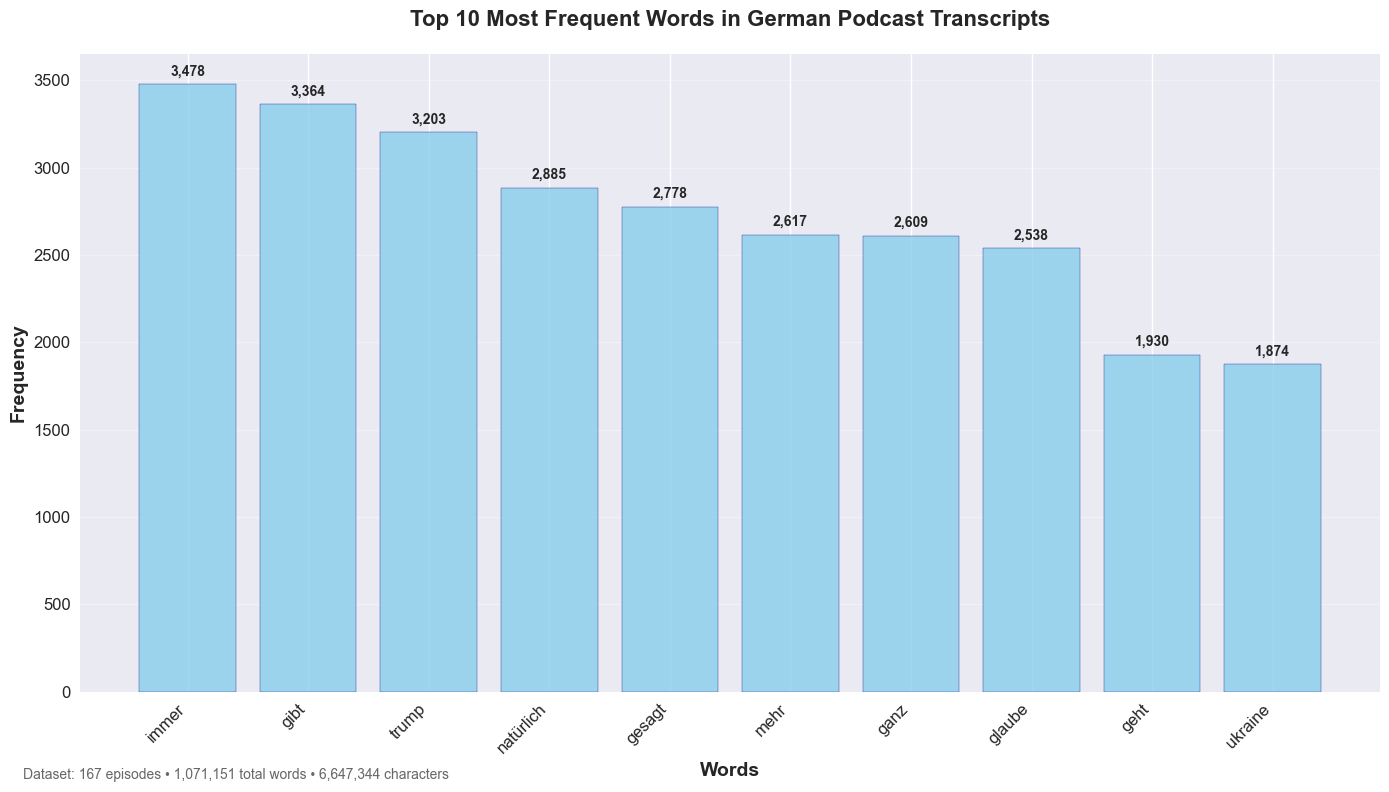

In [34]:
# Create visualization of top words
if len(df) > 0 and 'top_words' in locals():
    # Prepare data for plotting
    words, counts = zip(*top_words[:10])  # Top 10 for better visualization
    
    # Create bar plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(len(words)), counts, color='skyblue', alpha=0.8, edgecolor='navy')
    plt.xlabel('Words', fontsize=14, fontweight='bold')
    plt.ylabel('Frequency', fontsize=14, fontweight='bold')
    plt.title('Top 10 Most Frequent Words in German Podcast Transcripts', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xticks(range(len(words)), words, rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Add summary statistics
    total_episodes = len(df)
    total_words = df['word_count'].sum()
    total_chars = df['char_count'].sum()
    
    plt.figtext(0.02, 0.02, 
               f'Dataset: {total_episodes} episodes • {total_words:,} total words • {total_chars:,} characters',
               fontsize=10, alpha=0.7)
    
    plt.show()
    
else:
    print("📊 No data available for visualization")

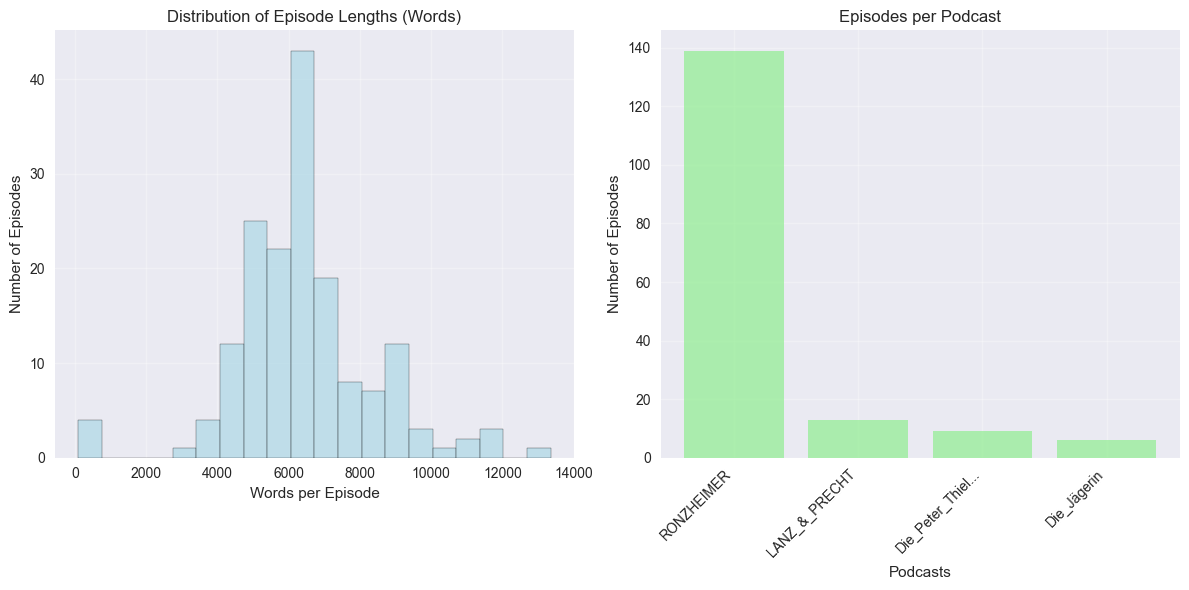

📊 Episode Length Statistics:
Mean: 6414 words
Median: 6340 words
Std Dev: 1971 words
Min: 94 words
Max: 13353 words


In [35]:
# Episode length distribution
if len(df) > 0:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(df['word_count'], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    plt.xlabel('Words per Episode')
    plt.ylabel('Number of Episodes')
    plt.title('Distribution of Episode Lengths (Words)')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    episodes_per_podcast = df['podcast_name'].value_counts()
    plt.bar(range(len(episodes_per_podcast)), episodes_per_podcast.values, color='lightgreen', alpha=0.7)
    plt.xlabel('Podcasts')
    plt.ylabel('Number of Episodes')
    plt.title('Episodes per Podcast')
    plt.xticks(range(len(episodes_per_podcast)), 
               [name[:15] + '...' if len(name) > 15 else name for name in episodes_per_podcast.index], 
               rotation=45, ha='right')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("📊 Episode Length Statistics:")
    print(f"Mean: {df['word_count'].mean():.0f} words")
    print(f"Median: {df['word_count'].median():.0f} words")
    print(f"Std Dev: {df['word_count'].std():.0f} words")
    print(f"Min: {df['word_count'].min():.0f} words")
    print(f"Max: {df['word_count'].max():.0f} words")

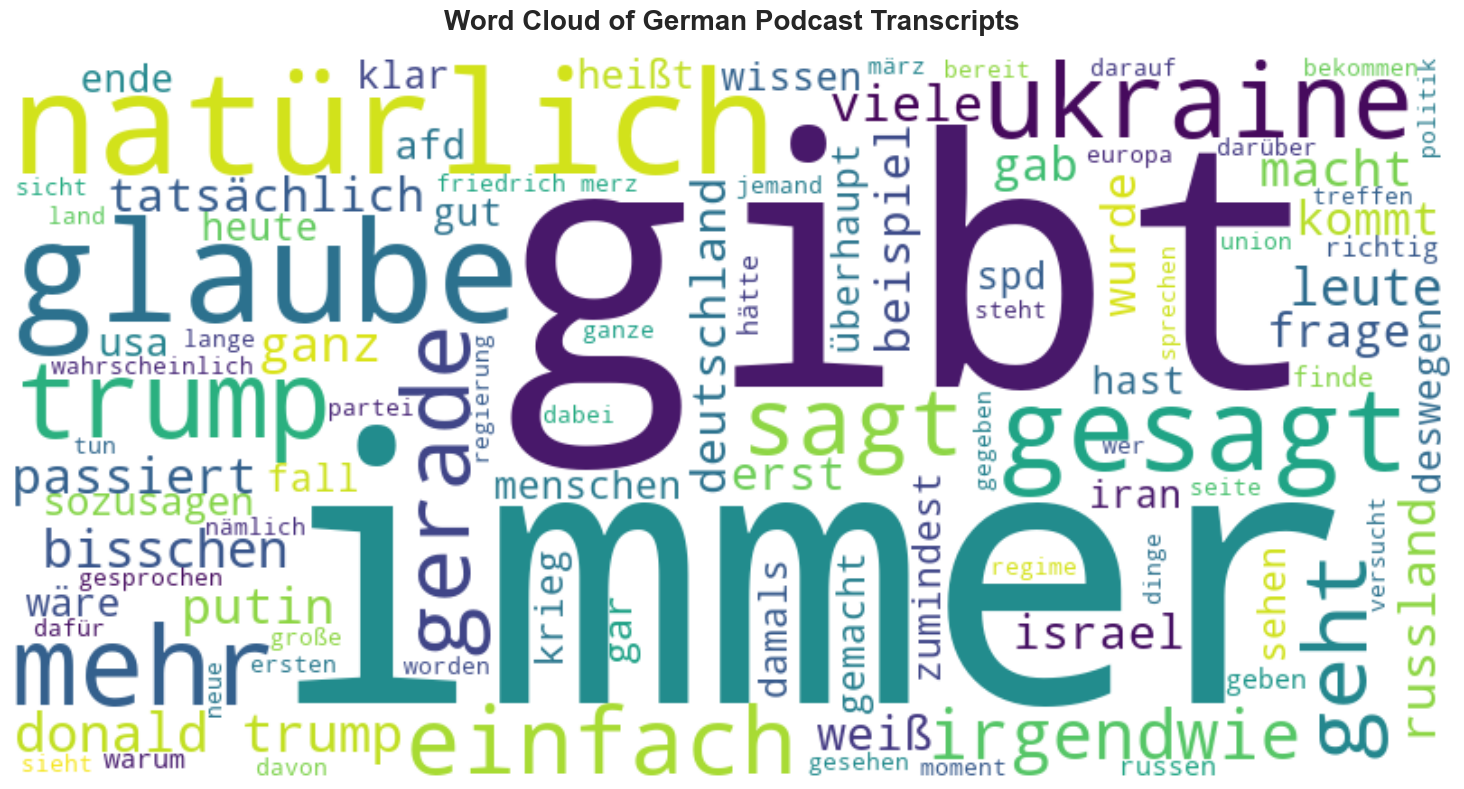

In [36]:
# Word cloud of most frequent terms
if len(df) > 0:
    try:
        # Combine all transcripts
        all_text = ' '.join(df['transcript'].fillna(''))
        
        # Clean the text
        all_words = extract_and_clean_words(all_text)
        clean_text = ' '.join(all_words)
        
        if clean_text:
            # Create word cloud
            wordcloud = WordCloud(
                width=800, 
                height=400, 
                background_color='white',
                max_words=100,
                colormap='viridis'
            ).generate(clean_text)
            
            plt.figure(figsize=(16, 8))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('Word Cloud of German Podcast Transcripts', 
                     fontsize=20, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ No words available for word cloud")
    except Exception as e:
        print(f"❌ Error creating word cloud: {e}")
        print("💡 Try installing wordcloud: pip install wordcloud")

Creating individual word clouds for 4 podcasts...
✅ Die_Jägerin: 6 episodes, 12,742 clean words
✅ Die_Peter_Thiel_Story: 9 episodes, 12,992 clean words
✅ LANZ_&_PRECHT: 13 episodes, 46,484 clean words
✅ RONZHEIMER: 139 episodes, 356,206 clean words


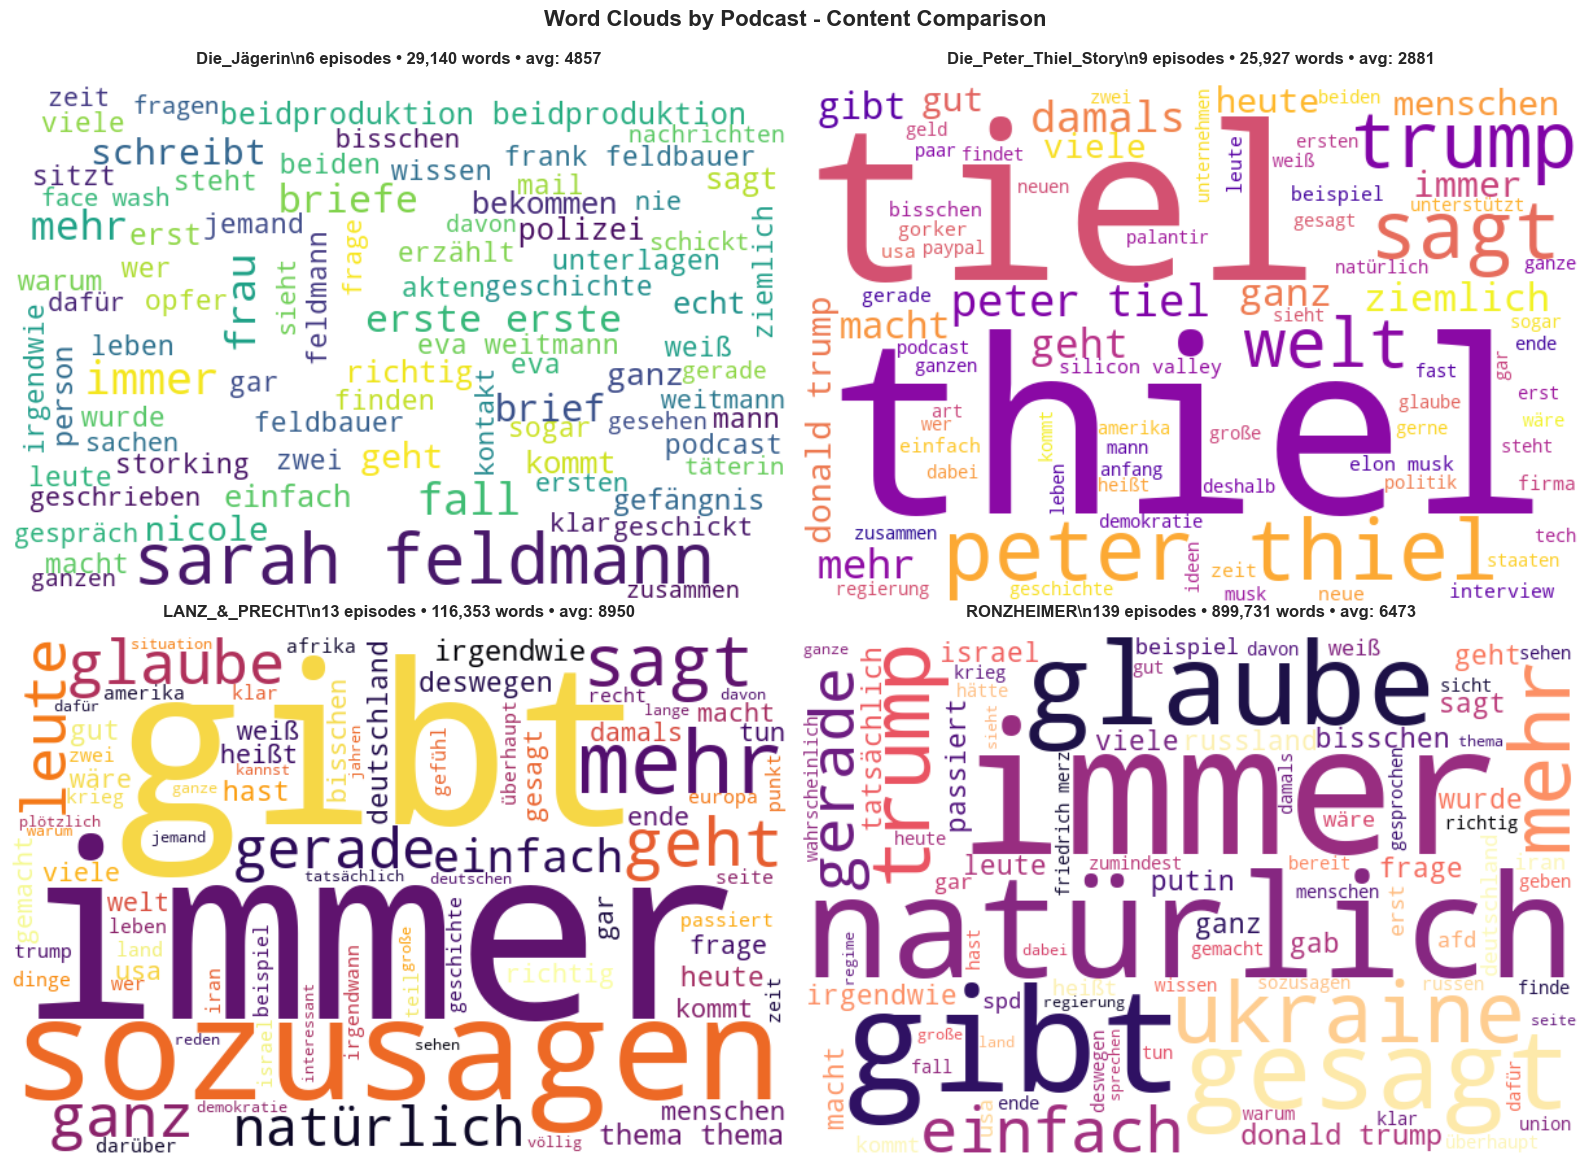

\n📊 PODCAST CONTENT COMPARISON:
\nDie_Jägerin:
  Episodes: 6
  Total words: 29,140
  Unique words: 4,005
  Vocabulary richness: 31.4%
  Top words: sarah, feldmann, fall, immer, feldbauer
\nDie_Peter_Thiel_Story:
  Episodes: 9
  Total words: 25,927
  Unique words: 5,058
  Vocabulary richness: 38.9%
  Top words: thiel, peter, tiel, trump, sagt
\nLANZ_&_PRECHT:
  Episodes: 13
  Total words: 116,353
  Unique words: 12,450
  Vocabulary richness: 26.8%
  Top words: immer, ganz, mehr, gibt, sozusagen
\nRONZHEIMER:
  Episodes: 139
  Total words: 899,731
  Unique words: 42,897
  Vocabulary richness: 12.0%
  Top words: trump, immer, gibt, natürlich, gesagt


<Figure size 1200x600 with 0 Axes>

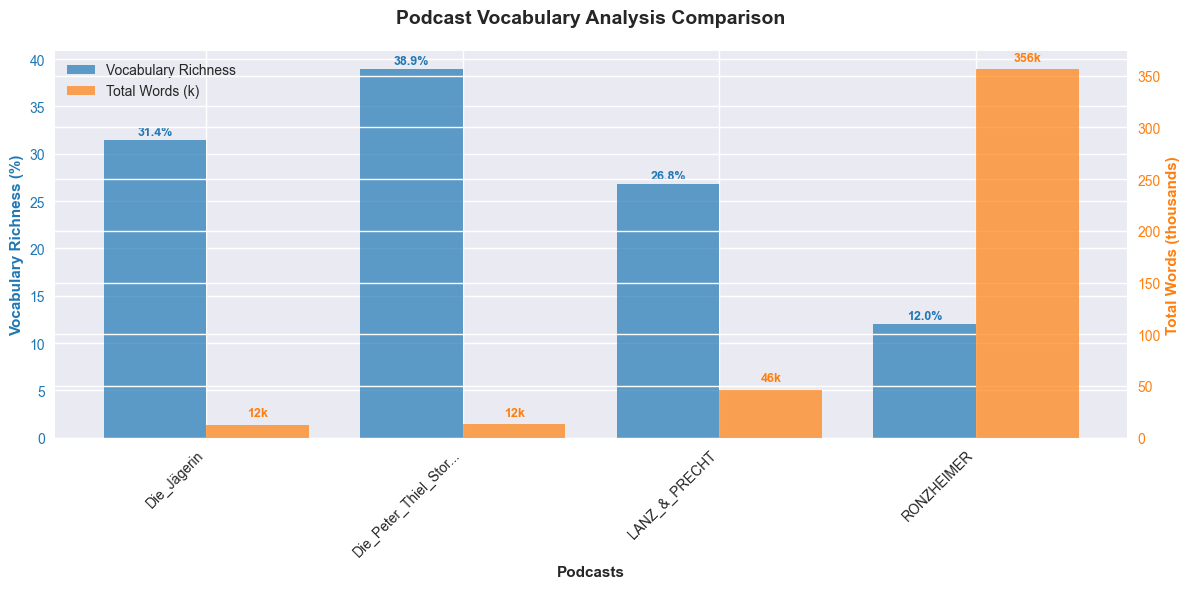

\n💡 Vocabulary Richness = (Unique Words / Total Words) × 100
   Higher richness indicates more diverse vocabulary usage


In [37]:
# Individual Word Clouds by Podcast for Comparison
if len(df) > 0:
    try:
        # Get unique podcasts
        unique_podcasts = df['podcast_name'].unique()
        n_podcasts = len(unique_podcasts)
        
        print(f"Creating individual word clouds for {n_podcasts} podcasts...")
        
        # Calculate subplot layout (prefer wider layout)
        if n_podcasts <= 2:
            rows, cols = 1, n_podcasts
            figsize = (8 * n_podcasts, 6)
        elif n_podcasts <= 4:
            rows, cols = 2, 2
            figsize = (16, 12)
        else:
            rows = (n_podcasts + 2) // 3  # Round up division by 3
            cols = 3
            figsize = (18, 6 * rows)
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        
        # Handle single subplot case
        if n_podcasts == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if n_podcasts > 1 else [axes]
        else:
            axes = axes.flatten()
        
        # Create word cloud for each podcast
        for i, podcast in enumerate(unique_podcasts):
            # Filter transcripts for this podcast
            podcast_df = df[df['podcast_name'] == podcast]
            podcast_text = ' '.join(podcast_df['transcript'].fillna(''))
            
            # Clean the text
            podcast_words = extract_and_clean_words(podcast_text)
            clean_podcast_text = ' '.join(podcast_words)
            
            if clean_podcast_text and len(podcast_words) > 10:
                # Create word cloud with unique colors for each podcast
                colormap_options = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Blues', 'Greens', 'Reds']
                selected_colormap = colormap_options[i % len(colormap_options)]
                
                wordcloud = WordCloud(
                    width=600,
                    height=400,
                    background_color='white',
                    max_words=80,
                    colormap=selected_colormap,
                    relative_scaling=0.5,
                    min_font_size=8
                ).generate(clean_podcast_text)
                
                # Plot word cloud
                ax = axes[i]
                ax.imshow(wordcloud, interpolation='bilinear')
                ax.axis('off')
                
                # Add title with episode count and word statistics
                episode_count = len(podcast_df)
                total_words = podcast_df['word_count'].sum()
                avg_words = total_words / episode_count if episode_count > 0 else 0
                
                title = f"{podcast}\\n{episode_count} episodes • {total_words:,} words • avg: {avg_words:.0f}"
                ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
                
                print(f"✅ {podcast}: {episode_count} episodes, {len(podcast_words):,} clean words")
            else:
                # Handle case with insufficient text
                ax = axes[i]
                ax.text(0.5, 0.5, f"{podcast}\\nInsufficient text\\nfor word cloud\\n({len(podcast_words)} words)", 
                       ha='center', va='center', transform=ax.transAxes, 
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
                ax.axis('off')
                ax.set_title(podcast, fontsize=12, fontweight='bold')
                
                print(f"⚠️ {podcast}: Insufficient text ({len(podcast_words)} words)")
        
        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        
        plt.suptitle('Word Clouds by Podcast - Content Comparison', 
                     fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()
        
        # Print comparison statistics
        print("\\n📊 PODCAST CONTENT COMPARISON:")
        print("=" * 50)
        
        for podcast in unique_podcasts:
            podcast_df = df[df['podcast_name'] == podcast]
            podcast_text = ' '.join(podcast_df['transcript'].fillna(''))
            podcast_words = extract_and_clean_words(podcast_text)
            
            # Get top 5 words for this podcast
            word_counts = Counter(podcast_words)
            top_5_words = word_counts.most_common(5)
            
            episode_count = len(podcast_df)
            total_words = podcast_df['word_count'].sum()
            unique_words = len(set(podcast_words))
            
            print(f"\\n{podcast}:")
            print(f"  Episodes: {episode_count}")
            print(f"  Total words: {total_words:,}")
            print(f"  Unique words: {unique_words:,}")
            print(f"  Vocabulary richness: {unique_words/len(podcast_words)*100:.1f}%" if podcast_words else "  Vocabulary richness: 0%")
            print(f"  Top words: {', '.join([word for word, count in top_5_words])}")
        
        # Create vocabulary comparison chart
        if n_podcasts > 1:
            plt.figure(figsize=(12, 6))
            
            podcast_names = []
            vocabulary_richness = []
            total_words_list = []
            
            for podcast in unique_podcasts:
                podcast_df = df[df['podcast_name'] == podcast]
                podcast_text = ' '.join(podcast_df['transcript'].fillna(''))
                podcast_words = extract_and_clean_words(podcast_text)
                
                unique_words = len(set(podcast_words))
                total_words = len(podcast_words)
                richness = (unique_words / total_words * 100) if total_words > 0 else 0
                
                podcast_names.append(podcast[:20] + '...' if len(podcast) > 20 else podcast)
                vocabulary_richness.append(richness)
                total_words_list.append(total_words)
            
            # Create dual-axis plot
            fig, ax1 = plt.subplots(figsize=(12, 6))
            
            # Bar plot for vocabulary richness
            color1 = 'tab:blue'
            ax1.set_xlabel('Podcasts', fontweight='bold')
            ax1.set_ylabel('Vocabulary Richness (%)', color=color1, fontweight='bold')
            bars1 = ax1.bar([x - 0.2 for x in range(len(podcast_names))], vocabulary_richness, 
                           width=0.4, color=color1, alpha=0.7, label='Vocabulary Richness')
            ax1.tick_params(axis='y', labelcolor=color1)
            ax1.set_xticks(range(len(podcast_names)))
            ax1.set_xticklabels(podcast_names, rotation=45, ha='right')
            
            # Second y-axis for total words
            ax2 = ax1.twinx()
            color2 = 'tab:orange'
            ax2.set_ylabel('Total Words (thousands)', color=color2, fontweight='bold')
            bars2 = ax2.bar([x + 0.2 for x in range(len(podcast_names))], 
                           [w/1000 for w in total_words_list], 
                           width=0.4, color=color2, alpha=0.7, label='Total Words (k)')
            ax2.tick_params(axis='y', labelcolor=color2)
            
            # Add value labels
            for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
                ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.2,
                        f'{vocabulary_richness[i]:.1f}%', ha='center', va='bottom', 
                        color=color1, fontweight='bold', fontsize=9)
                ax2.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 5,
                        f'{total_words_list[i]//1000}k', ha='center', va='bottom',
                        color=color2, fontweight='bold', fontsize=9)
            
            plt.title('Podcast Vocabulary Analysis Comparison', fontsize=14, fontweight='bold', pad=20)
            
            # Add legend
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
            
            plt.tight_layout()
            plt.show()
            
            print("\\n💡 Vocabulary Richness = (Unique Words / Total Words) × 100")
            print("   Higher richness indicates more diverse vocabulary usage")
        
    except Exception as e:
        print(f"❌ Error creating podcast word clouds: {e}")
        print("💡 Make sure wordcloud is installed: pip install wordcloud")
        
        # Fallback: Show text-based comparison
        print("\\nFallback - Text-based podcast comparison:")
        for podcast in df['podcast_name'].unique():
            podcast_df = df[df['podcast_name'] == podcast]
            all_text = ' '.join(podcast_df['transcript'].fillna(''))
            words = extract_and_clean_words(all_text)
            top_words = Counter(words).most_common(8)
            
            print(f"\\n{podcast} ({len(podcast_df)} episodes):")
            print(f"  Top words: {', '.join([word for word, count in top_words])}")
            
else:
    print("❌ No transcript data available for word cloud comparison")